# Kaggle Titanic survival - Monte Carlo Dropout

In 2016, Gal and Ghahramani introduced a simple but powerful technique for enhancing accuracy of neural networks, and providing a measure of uncertainty, without increasing training overhead.

Usually 'dropout', the random removal of neurones in a network, is used only in training (to reduce over-fitting to the training data). In Monte Carlo Dropout, dropout layers are used during evaluation as well. We obtain multiple estimates of classification probability, each using a different random selection of eliminated neurones. We can then take the mean across these models, and also look at the spread of probabilities in order to get a measure of model uncertainty.

The paper may be found at: https://arxiv.org/abs/1506.02142

This method does not require any change to the training of the network, and the implemtation therefasfter is simple!

We will use a simple model here, and just use a single training/test split so that we focus on the Monte Carlo Dropout method. In practice, k-fold validation should be used.

In [ ]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Download data if not previously downloaded

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [5]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net

In [6]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Define layers
    inputs = layers.Input(shape=number_features)
    dropout_0 = layers.Dropout(0.2)(inputs)
    
    dense_1 = layers.Dense(240, activation='relu')(dropout_0)
    dropout_1 = layers.Dropout(0.2)(dense_1)
    
    dense_2 = layers.Dense(50, activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.2)(dense_2)
  
    outputs = layers.Dense(1, activation='sigmoid')(dropout_2)
    
    
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net


## Show summary of the model structure

Here we will create a model with 10 input features and show the structure of the model as  atable and as a graph.

In [7]:
model = make_net(10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 240)               2640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51    

Note that the plot of the model shows how the imput layer is connected to both the first dense layer and the concatenation layer prior to the output.

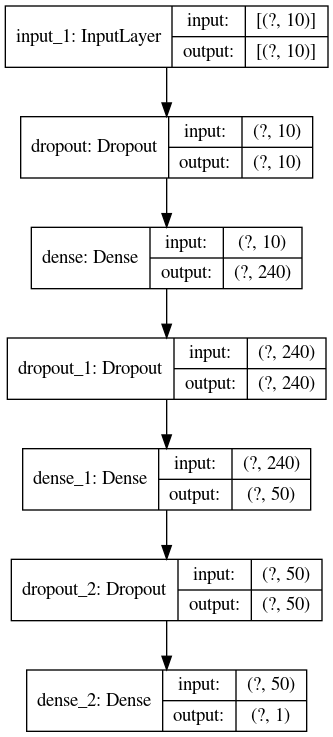

In [8]:
# If necessary conda install pydot and graphviz
keras.utils.plot_model(model, "titanic_tf_model.png", show_shapes=True)

## Training the model

In [9]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size = 0.25)

# Scale data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features)

# Train model
history = model.fit(X_train_sc,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

`history` is a dictionary containing data collected during training. Let's take a look at the keys in this dictionary (these are the metrics monitored during training):

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plot training history:

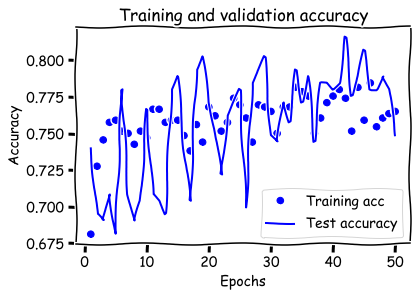

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

with plt.xkcd():
    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Monte Carlo Dropout

In Monte Carlo Dropout we maintain use of the dropout layers during evaluation (they are usually only used in training). Here we get estimates of survival probability from 30 different dropout configurations of the network.

Get multiple probability estimates:

In [12]:
num_estimates = 100
y_probas_dropout = np.stack(
    [model(X_test_sc, training=True) for sample in range (num_estimates)])

Get mean probabilities, and classify those with mean >= 0.5 as surviving.

In [13]:
y_proba_dropout = y_probas_dropout.mean(axis=0)
y_predict_dropout = y_proba_dropout >= 0.5
y_predict_dropout = y_predict_dropout.flatten()

Get normal predictions (without dropout)

In [14]:
# Get normal predictions (without dropout) 
y_proba = model.predict(X_test_sc)
y_predict = y_proba >= 0.5
y_predict = y_predict.flatten()

Show accuracy scores (we are doing a single test set here; in practice k-fold validation should be used).

In [15]:
accuracy = np.mean(y_predict == y_test)
accuracy_dropout = np.mean(y_predict_dropout == y_test)
print (f'Accuracy without dropout {accuracy:0.2f}')
print (f'Accuracy with dropout {accuracy_dropout:0.2f}')

Accuracy without dropout 0.75
Accuracy with dropout 0.74


Plot comparisons of dropout method and standard method.

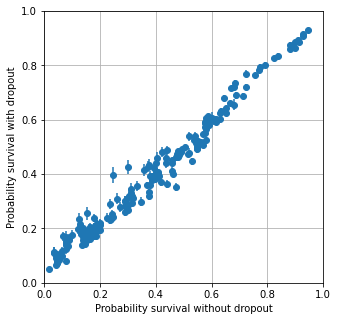

In [16]:
y_error = y_probas_dropout.std(axis=0)/np.sqrt(num_estimates)
fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(y_proba, y_proba_dropout, yerr = y_error, fmt='o')
ax.grid()
ax.set_xlabel('Probability survival without dropout')
ax.set_ylabel('Probability survival with dropout')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Show variation in prediction (across the dropout replicates) depending on probability of survival.

Here we will use standard error of the mean as one measure of uncertainty. Note how uncertainty is not even - there is less variation in prediction of those with high probability of survival compared with those with lower probability of survival.

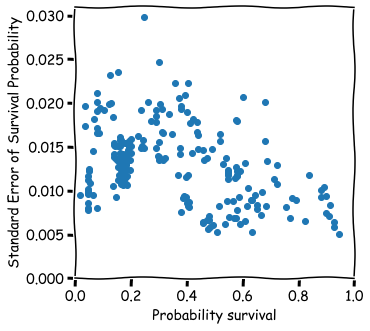

In [17]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(y_proba, y_error)
    ax.set_xlabel('Probability survival')
    ax.set_ylabel('Standard Error of Survival Probability')
    ax.set_xlim(0,1)
    ax.set_ylim(0)
    plt.show()

## Notes

If you wish to use other types oflayer that behave differently between training and test (such as batch normalization) then you should not use the method described above where the whole net is run in training mode. Rather you define a custome dropout layer class that is always set to behave as if it is in training mode. Tis is then used as a simple drop-in replacement for normal Dropout layers.

In [18]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)